In [1]:
from track_utils20long import *

In [7]:
cells = {}
cell_paths=[]
raw=[]
model=keras.models.load_model('CNN/model_time_3.keras') #load the model
files = glob.glob('D:/Tracking/Videos/20241212_MGH2100/0/*.h5', 
                   recursive = True)
files=natsorted(files)
subset_paths={'tmp': Path(r'CNN/tmp/')}
n=0
for file in files:
    print(file)
    double=False
    with h5py.File(file, 'r') as hf:
        video = hf['data'][:]
    imgs, saturations, volumes, x, hbmass = main_run(video)
    vol_df= pd.DataFrame(volumes)
    vol_df=vol_df.dropna()
    vol_list=vol_df[0].to_list()
    double=vol_step(vol_list)
    if double==False and (sum(vol_list) / len(vol_list))>50:
        raw.append(imgs[310])
        saturations=np.asarray(saturations)
        stack=chunk(video,10)
        i=0
        while i<len(stack):
            if len(stack[i])==10:
                padded_num = str(i).rjust(3, '0')
                name='CNN/tmp/data/'+padded_num+'.avi'
                save_stack(stack[i],name)
            # else:
                #todo add place holder
            i=i+1
        preds=CNN(subset_paths,model)
        np_preds=preds._numpy()
        n_preds=np.asarray([i[1] for i in np_preds])
        
        preds_interp = interp.interp1d(np.arange(n_preds.size),n_preds)
        preds_resamp = preds_interp(np.linspace(0,n_preds.size-1,saturations.size))
        df_name='df0_'+str(n)
        cell_paths.append(file)
        dict = {'sat': saturations, 'preds': preds_resamp} 
        # dict = {'imgs': imgs, 'sat': saturations, 'volumes': volumes, 'x': x[3:], 'hbmass': hbmass, 'preds': preds_resamp} 
        cells[df_name] = pd.DataFrame(dict)
        files = glob.glob('CNN/tmp/data//*')
        for f in files:
            os.remove(f)
    n=n+1

D:/Tracking/Videos/20241212_MGH2100/0\20241212_MGH2100_0_1.h5


c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode

D:/Tracking/Videos/20241212_MGH2100/0\20241212_MGH2100_0_2.h5


c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:233: RuntimeWarning: invalid value encountered in divide
  nimg=cell*(dilation)/sur
c:\Users\will6605\Documents\vscode\track_utils20long.py:236: RuntimeWarning: divide by zero encountered in log
  alf = -np.log(transmission)/channel
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:233: Runtim

ValueError: operands could not be broadcast together with shapes (20,38) (20,40) 

In [15]:

i=0
cell_sats = []
cell_preds =[]
raw_imgs = np.copy(raw)

while i<len(cells):
    saturations=cells[list(cells)[i]]['sat']
    sat=np.stack( saturations, axis=0 )
    pred=cells[list(cells)[i]]['preds']
    preds=np.stack( pred, axis=0 )
    preds=np.where(preds > 0.15, 1, 0)
    sat[(sat > 1) | (sat < -1)] = np.nan
    d = {'sat': sat, 'preds': preds}
    sat_df = pd.DataFrame(data=d)
    sat_df['sat_mean']=sat_df['sat'].rolling(window=5).mean() 
    sat_df['preds_mean']=sat_df['preds'].rolling(window=50).mean() 
    sat_mean=sat_df['sat_mean'].to_list()
    preds_mean=sat_df['preds_mean'].to_list()
    n = 355
    fill = [np.nan] * n
    sats = sat_mean#.append(fill[len(sat_mean):])
    predictions = preds_mean#.append(fill[len(preds_mean):])
    cell_sats.append(sats)
    cell_preds.append(predictions)
    i=i+1
saturations_df= pd.DataFrame(cell_sats)
predictions_df= pd.DataFrame(cell_preds)
predictions_df=predictions_df.T
saturations_df=saturations_df.T
saturations_df.columns = cell_paths
predictions_df.columns = cell_paths
# predictions_df.to_hdf('D:/Tracking/Videos/20241114_MGH2089/21/predictions_df.h5', key='data', mode='w')
# saturations_df.to_hdf('D:/Tracking/Videos/20241114_MGH2089/21/saturations_df.h5', key='data', mode='w')
# saturations_df.to_clipboard(sep=',') 
# predictions_df.to_clipboard(sep=',')   

In [17]:
n=5
del cell_sats[n]
del cell_preds[n]
del raw[n]

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
sig=True
axs = axs.ravel()

for i in range(len(cell_sats)):
    y=np.asarray(cell_sats[i][100:-50])
    ys=y[~np.isnan(y)]
    xs=np.linspace(0, len(ys),len(ys))

    if sig==True:
        try:
            p0 = [min(ys), max(ys),1]
            popt,pcov = curve_fit(exponential, xs, ys,p0, method='dogbox')
            P, Yo, k = popt
            sampleRate = 100 # Hz
            tauSec = (1 / k) / sampleRate
            tauS='{:.3}'.format(tauSec)


            # determine quality of the fit
            squaredDiffs = np.square(ys - exponential(xs, P, Yo, k ))
            squaredDiffsFromMean = np.square(ys - np.mean(ys))
            rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
            if rSquared>0.1:
                rsq='{:.3}'.format(rSquared)
                axs[i].plot(xs, ys, '.', label="data")
                axs[i].plot(xs, exponential(xs, P, Yo, k ), '--', label="fitted")
                axs[i].set_ylim([0, 1])
                axs[i].text(150,0.7,f"R² = {rsq}" , fontsize=10)
                axs[i].text(150,0.6,f"tau = {tauS}" , fontsize=10)
            else:
                pass
        except RuntimeError:
            print("Error - curve_fit failed")
            axs[i].plot(xs, ys, '.', label="data")
            axs[i].set_ylim([0, 1])
    else:
        try:
            p1 = [-0.01,00]
            popt,pcov = curve_fit(linear, xs, ys,p1, method='dogbox')
            m, b = popt
            slp='{:.3e}'.format(m)
            squaredDiffs = np.square(ys - linear(xs,m,b))
            squaredDiffsFromMean = np.square(ys - np.mean(ys))
            rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
            rsq='{:.3}'.format(rSquared)
            axs[i].plot(xs, ys, '.', label="data")
            axs[i].plot(xs, linear(xs,m,b), '--', label="fitted")
            axs[i].set_ylim([-0.1, 1])
            axs[i].text(50,0.7,f"R² = {rsq}" , fontsize=10)
            axs[i].text(50,0.6,f"slope = {slp}" , fontsize=10)
        except RuntimeError:
            print("Error - curve_fit failed")
            pass

 


In [ ]:
fig, axs = plt.subplots(6,5, figsize=(15, 18), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
sig=True
axs = axs.ravel()

for i in range(len(cell_preds)):
    y=np.asarray(cell_preds[i][100:-50])
    ys=y[~np.isnan(y)]
    xs=np.linspace(0, len(ys),len(ys))
    axs[i].plot(xs, ys, '.', label="data")
    axs[i].set_ylim([0, 1])


In [ ]:
fig, axs = plt.subplots(6,5, figsize=(15, 18), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(len(raw)):
    axs[i].imshow(raw[i], cmap='grey')

In [25]:
# predictions_df.to_hdf('predictions_df.h5', key='data', mode='w')
# saturations_df.to_hdf('saturations_df.h5', key='data', mode='w')
# saturations_df=pd.read_hdf('D:/Tracking/Videos/20241114_MGH2089/21/saturations_df.h5', 'data')
# predictions_df=pd.read_hdf('D:/Tracking/Videos/20241114_MGH2089/21/predictions_df.h5', 'data')
# predictions_df2=pd.read_hdf('predictions_df.h5', 'data')    
times=([(predictions_df[100:]<0.1).idxmax(axis=0)])[0]
# sns.lineplot(data=predictions_df[1])
times.to_clipboard(sep=',',index=False) 
# saturations_df.to_clipboard(sep=',') 

In [8]:
with h5py.File('D:/Tracking/Videos/20241212_MGH2100/0/20241212_MGH2100_0_2.h5', 'r') as hf:
    video = hf['data'][:]


In [ ]:
veiw(video)

In [9]:
stack=chunk(video,10)

c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter


ValueError: operands could not be broadcast together with shapes (20,38) (20,40) 

In [51]:
model=keras.models.load_model('CNN/model_time_3.keras') #load the model
i=0
while i<len(stack):
    if len(stack[i])==10:
        padded_num = str(i).rjust(3, '0')
        name='CNN/tmp/data/'+padded_num+'.avi'
        save_stack(stack[i],name)
    # else:
        #todo add place holder
    i=i+1
# preds=CNN(subset_paths,model)

In [6]:
imgs, saturations, volumes, x, hbmass = main_run(video)

c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode\track_utils20long.py:199: RuntimeWarning: invalid value encountered in scalar divide
  circ = 2*np.sqrt(np.pi*area)/perimeter
c:\Users\will6605\Documents\vscode

In [ ]:
def crop(frame, pt430, pt410): 
    frames=[]
    c=[]
    pad=[20,-20]
    top=[np.mean(frame[2][int(0):int(10), int(0):int(40)]),np.mean(frame[3][int(0):int(10), int(0):int(40)])]
    xs=[pt430[0],pt410[0],pt430[0],pt410[0]]
    # ys=[pt430[1],pt410[1],pt430[1],pt410[1]]
    i=0
    for f in frame[2:]:
        img=(f[int(0):int(270), int(xs[i]-20):int(xs[i]+20)])
        Gy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
        aGy=abs(Gy)
        imGy=np.copy(img)
        grad=np.median(aGy,axis=1)
        grad=np.where(grad > 30, 0, 1)
        wall=np.where(grad == 0)[0]
        gap=np.diff(wall)
        chan=[wall[np.argmax(gap)-1]+1, wall[np.argmax(gap)+1]-1]
        clo=(np.abs(chan - pt410[1])).argmin()
        chan[clo-1]=chan[clo]+pad[clo]
        c.append(chan)
        i=i+1
    frames=[frame[0][int(c[0][0]):int(c[0][1]), int(xs[0]-20):int(xs[0]+20)],frame[1][int(c[1][0]):int(c[1][1]), int(xs[1]-20):int(xs[1]+20)],frame[2][int(c[0][0]):int(c[0][1]), int(xs[0]-20):int(xs[0]+20)],frame[3][int(c[1][0]):int(c[1][1]), int(xs[1]-20):int(xs[1]+20)]]
    return frames, top

def masking(img):
    cx=0;cy=0
    img=img.astype('uint8')
    cell_mask = np.zeros_like(img)
    masked = np.zeros_like(img)
    ret, thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU) 
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
            # Calculate area and remove small elements
            area = cv.contourArea(cnt)  
            hull = cv.convexHull(cnt)
            perimeter = cv.arcLength(hull, True)  
            # x, y, w, h = cv.boundingRect(cnt)   
            area = cv.contourArea(hull, True)
            circ = 2*np.sqrt(np.pi*area)/perimeter
            if area > 50 and area < 1000 and circ>0.7:
                cell_mask = np.zeros_like(img)
                masked = np.zeros_like(img)
                M = cv.moments(cnt)
                if M['m00'] != 0:
                    cx = int(M['m10']/M['m00'])
                    cy = int(M['m01']/M['m00'])
                
                cv.drawContours(cell_mask, [hull], -1,(1), -1)
                img=rescale(img)
                cell=(img)
                cell_mask=(cell_mask)
                masked=rescale_blue(cell,cell_mask)
                
    if masked.shape!=(20,40) or cell_mask.shape!=(20,40):
            masked=np.zeros((20,40))
            cell_mask=np.zeros((20,40))
    
    return masked, cell_mask, cx, cy

#calulcate the volume on the cell
def volume(cell, mask, top):
    channel=11
    # x=pt[0]; y=pt[1]
    # cell=(img[int(y-15):int(y+15), int(x-20):int(x+20)])
    if len(mask[0])<30:
        vol=np.nan
    else:
        kernel = np.ones((5,5),np.uint8)
        dilation = cv.dilate(mask,kernel,iterations = 1)
        masked = (cell*(mask))
        sur=np.mean(masked)
        parea=(6.9/20)**2
        nimg=cell*(dilation)/sur
        nimg[nimg <= 0] = 0.01
        transmission = sur/top
        alf = -np.log(transmission)/channel
        tcell=np.log(nimg)/alf
        vol=np.sum(tcell*mask)*parea
    return vol
   
def saturation(frames): #Calcuate cell saturation
     #camera pixel area
    b=[frames[0],frames[1]]
    #Molecular absorbtion coefficints of something like that ~chemistry~
    w430_o = 2.1486*(10**8)
    w430_d = 5.2448*(10**8)
    w410_o = 4.6723*(10**8)
    w410_d = 3.1558*(10**8)

    mass410=mass(b[1])
    mass430=mass(b[0])
    
    e=mass410 #410
    f=mass430 #430
    #Set absorbtion values to equation constants
    a=w410_d
    b=w410_o
    c=w430_d
    d=w430_o
                
    #Calcuate mass of oxygenated and deoxygenated hemoglobin
    Mo=(a*f-e*c)/(a*d-b*c)
    Md=(e*d-b*f)/(a*d-b*c)

    saturation = Mo/(Mo+Md)
    hbmass=e+f
    # print(Mo)
    # print('$')
    # print(Md)
    return saturation, hbmass

#resize the images, and process them for the neural net
def net(frames, top):

    B430 = frames[0]
    B410 = frames[1]
    imgR430 = frames[2]
    imgR410 = frames[3]

    imgB430, mask430, cx430, cy430=masking(B430)
    imgB410, mask410, cx410, cy410=masking(B410)

    mask430[mask430<0] = 0
    mask410[mask410<0] = 0
    imgB410[imgB410<0] = 0
    imgB430[imgB430<0] = 0
    imgR410[imgR410<0] = 0
    imgR430[imgR430<0] = 0


    vol430=volume(imgR430, mask430, top[0])
    vol410=volume(imgR410, mask410, top[1])
    ## todo get cx and make square

    imgR410=rescale(imgR410)
    imgR410=rescale_red(imgR410,mask410)
    imgR430=rescale(imgR430)
    imgR430=rescale_red(imgR430,mask430)

    imgB430=np.pad(imgB430, 10, mode='constant')
    imgB410=np.pad(imgB410, 10, mode='constant')
    imgR430=np.pad(imgR430, 10, mode='constant')
    imgR410=np.pad(imgR410, 10, mode='constant')
    

    imgB430=(imgB430[int(cy430):int(cy430+20), int(cx430):int(cx430+20)])
    imgB410=(imgB410[int(cy410):int(cy410+20), int(cx410):int(cx410+20)])
    imgR430=(imgR430[int(cy430):int(cy430+20), int(cx430):int(cx430+20)])
    imgR410=(imgR410[int(cy410):int(cy410+20), int(cx410):int(cx410+20)])

    imgR=imgR430/2+imgR410/2

    imgB430=cv.resize(imgB430, dsize=(81, 81), interpolation=cv.INTER_LINEAR)
    imgB410=cv.resize(imgB410, dsize=(81, 81), interpolation=cv.INTER_LINEAR)
    imgR=cv.resize(imgR, dsize=(81, 81), interpolation=cv.INTER_LINEAR)
    img = np.zeros([81,81,3])
    img[:,:,0] = imgB430
    img[:,:,1] = imgB410
    img[:,:,2] = imgR
    
    vol=(vol430+vol410)/2
    return img, vol

In [59]:
BL=getBL()
i=10
x_old=0
y_old=0
saturations=[]
img=[]
volumes=[]
hgb=[]
x=[0,0,0]
y=[0,0,0]
# while i<len(video):
frame1=video[i][0:2]
frame2=video[i][2:4]
frame3=video[i][2:6]
frame4=video[i][6:8]
frames=[frame1,frame2, frame3, frame4]
for frame in frames:
    x_old=np.mean(x[-3:])
    y_old=np.mean(y[-3:])
    pt430, pt410, frame = segment(frame,x_old, y_old,BL)
    # print(pt430)
    # print(pt410)
    if pt430[0]>21 and pt410[0]>21 and pt430[0]<339 and pt410[0]<339 and pt430[1]>11 and pt410[1]>11 and pt430[1]<239 and pt410[1]<239:
        frames, top=crop(frame,pt430,pt410)
        # plt.imshow(frames[1])
        # plt.show()
        # plt.imshow(frames[2])
        sats, hbmass=saturation(frames)
        # saturations.append(sats)
        # hgb.append(hbmass)
        img, vol=net(frames, top)
    # cv.putText(gray, str('%.2f' %sat), (locx-45,locy-45), cv.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
        # cv.imshow('Single Track', img)
#                     # # # press 'q' to break loop and close window
        # cv.waitKey(5)
    # i=i+1
#     # print(xf)
# cv.destroyAllWindows()
# plt.imshow(img)


C:\Users\will6605\AppData\Local\Temp\ipykernel_70572\522788866.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satna_df['sat_mean']=satna_df['sat'].rolling(window=10).mean()
C:\Users\will6605\AppData\Local\Temp\ipykernel_70572\522788866.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satna_df['vols_mean']=satna_df['volumes'].rolling(window=5).mean()


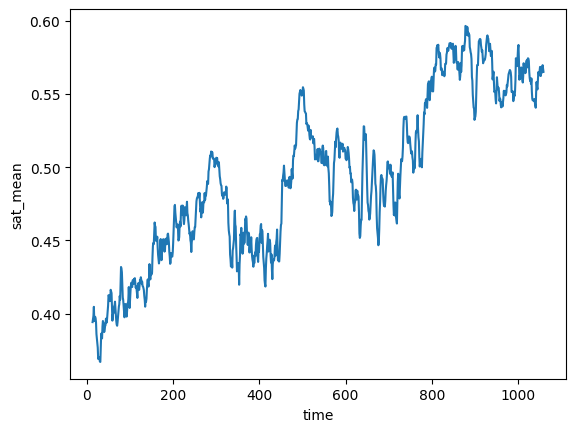

In [15]:
sat=np.stack( saturations, axis=0 )
sat[(sat > 1) | (sat < -1)] = np.nan
vols=np.stack( volumes, axis=0 )
vols[(vols > 200) | (vols < 0)] = np.nan
# hgb=np.stack( hbmass, axis=0 )
# hgb[(hgb > 1) | (hgb < 0)] = np.nan
# chcm=10000*hgb/vols
t=np.linspace(1,len(saturations), len(saturations))
# sns.lineplot(y=chcm, x=t)
d = {'time': t, 'sat': sat, 'volumes': vols}# 'mch': hgb, 'chcm' :chcm}
sat_df = pd.DataFrame(data=d)
satna_df=sat_df.dropna()
satna_df['sat_mean']=satna_df['sat'].rolling(window=10).mean() 
satna_df['vols_mean']=satna_df['volumes'].rolling(window=5).mean() 
satna_df=satna_df.dropna()
fig, ax = plt.subplots()

# sns.lineplot(data=satna_df, x='time', y='vols_mean', ax=ax)
sns.lineplot(data=satna_df, x='time', y='sat_mean', ax=ax)
# ax.set_ylim(-0.1, 1)
plt.show()

In [13]:
preds=CNN(subset_paths,model)
np_preds=preds._numpy()

3/3 [==============================] - 0s 56ms/step


In [14]:
n_preds=np.asarray([i[1] for i in np_preds])
preds_interp = interp.interp1d(np.arange(n_preds.size),n_preds)
preds_resamp = preds_interp(np.linspace(0,n_preds.size-1,saturations.size))

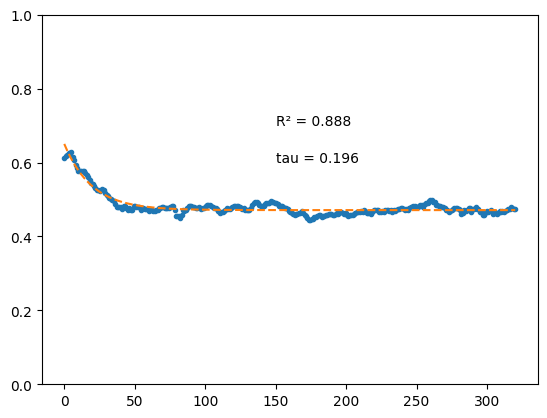

In [35]:
def exponential(x,P,Yo,k):
    y=P + ( Yo - P ) * np.exp( -k * x)
    return(y)


y=np.asarray(cell_sats[i][100:-50])
ys=y[~np.isnan(y)]
xs=np.linspace(0, len(ys),len(ys))

try:
    p0 = [min(ys), max(ys),1]
    popt,pcov = curve_fit(exponential, xs, ys,p0, method='dogbox')
    P, Yo, k = popt
    sampleRate = 100 # Hz
    tauSec = (1 / k) / sampleRate
    tauS='{:.3}'.format(tauSec)


    # determine quality of the fit
    squaredDiffs = np.square(ys - exponential(xs, P, Yo, k ))
    squaredDiffsFromMean = np.square(ys - np.mean(ys))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    rsq='{:.3}'.format(rSquared)
    plt.plot(xs, ys, '.', label="data")
    plt.plot(xs, exponential(xs, P, Yo, k ), '--', label="fitted")
    plt.ylim([0, 1])
    plt.text(150,0.7,f"R² = {rsq}" , fontsize=10)
    plt.text(150,0.6,f"tau = {tauS}" , fontsize=10)
except RuntimeError:
    print("Error - curve_fit failed")
